### Introduction

Model inspired by this paper: http://www.stat.columbia.edu/~gelman/research/published/election15Feb.pdf
<br> and derives many functions from Joseph Richards work: https://github.com/jwrichar/bayesian_election_forecasting

The model tries to estimate a posterior for statewise democratic-share based on past election results and polling data.

<br>

**Is polling fundamentally useful if done right?**<br>
Let's estimate the sampling variance of an average poll. In our data, we see that most polls are around 600-700 in size:

$ SD = \sqrt {\dfrac {p_0(1-p_0)}{600}} = 0.02$

The small value of SD shows that variability due to sampling would be low enough to make the results informative. However, this assumes the polls were created by randomly sampling, which they are not.

<br><br>
For each state:

$p_0$: democratic share in the actual election. So if $p_0$ is more than 0.5 for a certain state, it means Democrats won that state <br>
$p_t$: the true proportion (in the given state) who intended to vote for the Democratic candidate, _t months_
before the election <br>
$\hat{p}_t$: denotes our estimate of $p_t$ from a preelection poll <br>
$p_{2020}$: democratic share of the given state in 2020 election

The goal is to estimate the posterior $p_0$ given $p_t$ and $p_{2020}$. While it's possible to incorporate older election results, my model relies solely on data from the 2020 election (for this calculation), as it has been shown to have the strongest correlation with the current election.


** Assumptions **
 - $p_t$ has a normal distribution with mean $p_0$ and variance computed emiprically as a function of _months t_ before the election
 - $\hat{p}_t$ has a normal distribution with mean $p_t$ and variance a function of $p_t$ and $p_0$.<br>
 This assumes that CLT holds true for polling which is not the case. In practice $\hat{p}_t$ is an underestimate of survey error, given clustering, weighting, and other issues that depart from simple random sampling.
 
Our goal is to try and estimate $var(\hat{p_t}  | p_0)$<br><br>

$var(\hat{p_t} | p_0) = E (var(\hat{p_t} | p_t) | p_0) + var (E(\hat{p_t} | p_t) | p_0)$  ... law of total variance <br><br>
$            = E(\dfrac{p_t(1-p_t)}{n} | p_0) + var (p_t | p_0)$      ... Assumes CLT on $\hat{p}_t$, which isn't true <br>

$= \dfrac{E(p_t| p_0)- E(p_t^2| p_0)}{n} + var (p_t | p_0)$ <br>

<br>Let's examine the term $ E(p_t^2 | p_0)$  <br><br>
 $\text{var}(p_t | p_0) = E(p_t^2 | p_0) - E(p_t | p_0)^2$ <br><br>
 $E(p_t^2 | p_0) = \text{var}(p_t | p_0) + E(p_t | p_0)^2$ <br><br><br>

Substituting the result back, we get <br>

$var(\hat{p_t} | p_0) = \dfrac{E(p_t | p_0) - var(p_t | p_0) - E(p_t | p_0)^2}{n} + \text{var}(p_t | p_0) $ <br><br>

$var(\hat{p_t} | p_0) = \dfrac{p_0 - var(p_t | p_0) - p_0^2}{n} + \text{var}(p_t | p_0) $ <br><br>


$var(\hat{p_t} | p_0) = \dfrac{p_0(1-p_0)}{n} + \dfrac{n-1}{n} \text{var}(p_t | p_0) $ <br><br>

$            = \dfrac{p_0(1-p_0)}{n} + \dfrac{n-1}{n}var (p_t | p_0)$ <br>
$           \sim \dfrac{p_0(1-p_0)}{n} + var (p_t | p_0)$ <br>

<br>
This gives:<br>
Estimate of $var(p_t | p_0) =  var(\hat{p_t} | p_0) -  \dfrac{p_0(1-p_0)}{n} $


The first term is basically the variance of the polling data. Since we know p_0 for the last election and variance of polling data (for each month), we can compute the value of $var(p_t | p_0)$ as a function of t.

Empirically, $var(p_t | p_0)$ comes to be about $0:0002t$ using weighted least squares fitting (t is the number of months before election)

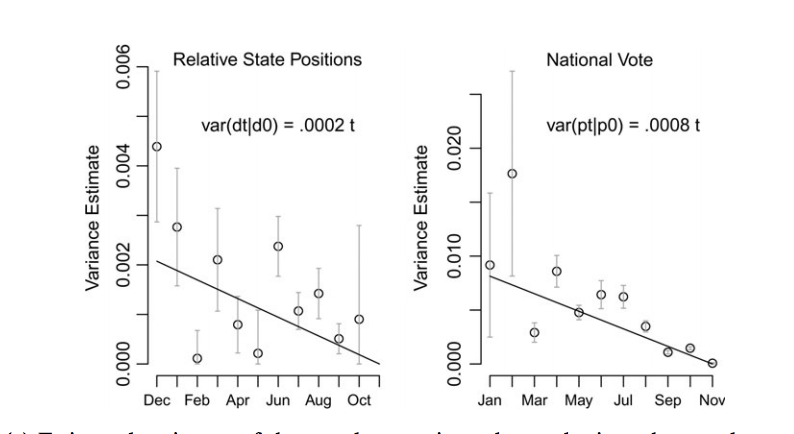

<br><br>
Final step: Posterior

$ \hat{p_t}|p_0 \sim N\Big( p_0,  \dfrac{p_0(1-p_0)}{n} + var (p_t | p_0) \Big)$

$ p_0 | p_{2020} \sim N\Big( p_{2020}, var(p_0 | p_{2020})\Big)$

<br>
Now, $var (p_t | p_0) \sim 0.0002t$ <br>
$var(p_0 | p_{2020})$ can be estimated from historical elections  <br>
$p_{2020}$ is known  <br>

We use MCMC sampling to estimate the distribution of $p_0$ by using observed values of $p_t$ from polling data

In [1]:
import pymc3 as pm
from entity import State, National
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt

from poll_data import get_polls, past_state_election_results

print("Running on PyMC3 v{}".format(pm.__version__))

The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.


Running on PyMC3 v3.11.6


# 2024 Election analysis

### Load election data

In [10]:
import importlib
import poll_data
import entity

# Reload the module to apply any changes
importlib.reload(poll_data)
importlib.reload(entity)

# Now, you can use get_polls and past_state_election_results
from poll_data import get_polls, past_state_election_results
from entity import State, National


state_polls, national_polls = get_polls(2024, refresh=False)
df_past_elections = past_state_election_results()

# load poll data into State and National aindata objects
states = [State(abbr, df, df_past_elections.loc[abbr]) for abbr, df in state_polls.items()]
national = National(national_polls)

Using pre-downloaded polls


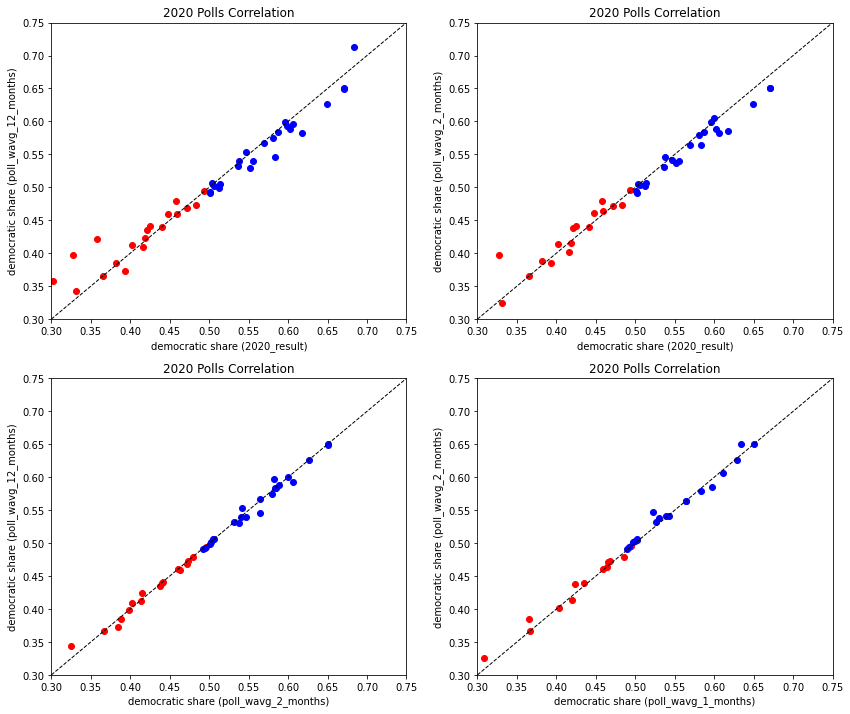

In [27]:
# state.get_weighted_average_poll_dem_share_months_before_election(months=1))
df_polls = pd.DataFrame([
    {
        "state": state.abbr,
        "poll_wavg_12_months": state.get_weighted_average_poll_dem_share(12),
        "poll_wavg_5_months": state.get_weighted_average_poll_dem_share(5),
        "poll_wavg_2_months": state.get_weighted_average_poll_dem_share(2),
        "poll_wavg_1_months": state.get_weighted_average_poll_dem_share(1),
        "2020_result": state.get_dem_share(2020),
        "party": 'B' if state.get_dem_share(2020) > 0.5 else 'R'
    }    
     for state in states if len(state.polls) > 0
])
df_red = df_polls[df_polls.party == 'R']
df_blue = df_polls[df_polls.party == 'B']

# fig, ax = plt.subplots()
fig, axes = plt.subplots(2, 2, sharey=False)
fig.set_size_inches(14, 12)

cols = [('2020_result', 'poll_wavg_12_months'), ('2020_result', 'poll_wavg_2_months'), 
        ('poll_wavg_2_months', 'poll_wavg_12_months'), ('poll_wavg_1_months', 'poll_wavg_2_months')]

for i, (xcol, ycol) in enumerate(cols):
    ax = axes[i//2,  i%2]
    df_red.plot(x=xcol, y=ycol, style='ro', ax=ax)
    df_blue.plot(x=xcol, y=ycol, style='bo', ax=ax)
    ax.plot([0,1],[0,1], transform=ax.transAxes, color='black', linestyle='--', linewidth=1)
    ax.set_title('2020 Polls Correlation')
    ax.set_ylabel(f"democratic share ({ycol})")
    ax.set_xlabel(f"democratic share ({xcol})")
    
    ax.set_xlim([0.3, 0.75]); ax.set_ylim([0.3, 0.75])
    ax.get_legend().remove()

#### Polling bias

In [ ]:
for col in ['poll_wavg_1_months', 'poll_wavg_12_months']:
    # red_bias = (df_red[col] - df_red["2016_result"]).mean()
    red_bias = (df_red[col].mean() - df_red["2020_result"].mean())
    blue_bias = (df_blue[col].mean() - df_blue["2020_result"].mean())
    print("\nBias in polls ranging over last %s:" % col.replace("poll_wavg_", "").replace("_", " "))
    print("Red states: %.3f" % red_bias)
    print("Blue states: %.3f" % blue_bias)
    print("Red variance: %.3f" % (df_red[col] - df_red["2020_result"]).std())
    print("Blue variance: %.3f" % df_blue[col].std())


In [33]:
df_red['polling_error'] = df_red['poll_wavg_2_months'] - df_red['2020_result']
df_red.sort_values('polling_error').tail(10)

/tmp/ipykernel_30716/654069466.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_red['polling_error'] = df_red['poll_wavg_2_months'] - df_red['2020_result']


,state,poll_wavg_12_months,poll_wavg_5_months,poll_wavg_2_months,poll_wavg_1_months,2020_result,party,polling_error
35,TN,0.3846,0.3846,0.3878,NaN,0.381722,R,0.006078
20,NE,0.4120,0.4120,0.4135,0.4200,0.402159,R,0.011341
0,AK,0.4600,0.4600,0.4609,0.4595,0.447382,R,0.013518
12,KS,0.4412,0.4412,0.4412,NaN,0.425066,R,0.016134
18,MO,0.4354,0.4354,0.4383,0.4236,0.421642,R,0.016658
43,WY,0.2942,0.2942,0.2942,0.2775,0.275196,R,0.019004
11,IA,0.4794,0.4794,0.4794,0.4853,0.458167,R,0.021233
27,ND,0.3980,0.3980,0.3980,NaN,0.327826,R,0.070174
2,AR,0.4211,0.4211,NaN,NaN,0.357876,R,NaN
41,WV,0.3579,0.3579,NaN,NaN,0.302015,R,NaN


## 2024 Forecasting

### Load Election Data

In [37]:
state_polls, national_polls = get_polls(2024, refresh=False)
df_past_elections = past_state_election_results()

# load poll data into State and National aindata objects
states = [State(abbr, df, df_past_elections.loc[abbr]) for abbr, df in state_polls.items()]
national = National(national_polls)

Using pre-downloaded polls


### Model Fitting

In [80]:
import numpy as np

def train_model(apply_pollster_bias_correction=False):

    b0 = 0
    election_model = pm.Model()

    # Model inspired by http://www.stat.columbia.edu/~gelman/research/published/election15Feb.pdf
    with election_model:
        for state in states:
            # prior for each state
            # TODO: compute variance for each state from the past elections
            # Choosing 0.029 for now from 
            if apply_pollster_bias_correction:
                bias_prior = poll_avg_2020.get(state.abbr, np.nan) - state.get_dem_share(2020)
                bias_prior = 0 if pd.isnull(bias_prior) else bias_prior
                b0 = pm.Normal("b_%s" % state.abbr, mu=bias_prior, sigma=0.005)

            p0 = pm.Normal("p_%s" % state.abbr, mu=state.get_dem_share(2020), sigma=0.04)

            p_dems = np.array([p.p_dem for p in state.polls])
            months_to_election = np.array([p.months_from_election for p in state.polls])
            poll_sizes = np.array([p.size for p in state.polls])

            if len(poll_sizes) > 0:
                sigma = np.sqrt(1.0 * (p0) * (1-p0) / poll_sizes + 0.0002 * months_to_election)
            else:
                sigma = 0.005

            Y_obs = pm.Normal("Y_obs_%s" % state.abbr, mu=p0+b0, sigma=sigma, observed=p_dems)

        trace = pm.sample(5000, init='adapt_diag')
    return trace


In [81]:
trace_regular = train_model(apply_pollster_bias_correction=False)
trace_correction = train_model(apply_pollster_bias_correction=True)

The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 40 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construc

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Can

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 103 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul,no_inplace}.0
WARNING (theano.tensor.opt): Cannot

In [140]:
def compile_results(trace):
    ff = []
    for state in states:
        samples = trace.get_values('p_%s' % state.abbr)
        ff.append({
            "abbr": state.abbr, 
            "prior": state.get_dem_share(2020), 
            "posterior": samples.mean(),
            "polls": state.get_weighted_average_poll_dem_share(2),            
            "p_win": (samples > 0.5).mean()
        })
    df_results = pd.DataFrame(ff)
    df_results['democrat'] = (df_results.posterior >= 0.5)
    
    # Compute total electoral vote
    df_electoral = pd.read_csv("../data/electoral_college.csv").set_index('abbr')
    dem_states = df_results[df_results['democrat']].abbr.tolist()
    rep_states = df_results[~df_results['democrat']].abbr.tolist()

    dem, rep = df_electoral.loc[dem_states].votes.sum(), df_electoral.loc[rep_states].votes.sum()

    return df_results, (dem, rep)

## Results without correction

In [199]:
df_results_reg, (elect_dem, elect_rep) = compile_results(trace_regular)

In [86]:
df_results_reg[(df_results_reg.prior < 0.5) & (df_results_reg.posterior >= 0.5)]

,abbr,prior,posterior,polls,p_win,democrat


### Electoral College

In [200]:
print("Harris: %d Trump: %d" % (elect_dem, elect_rep))

Harris: 273 Trump: 265


In [134]:
import plotly.express as px  # Be sure to import express
px.choropleth?

In [193]:
def plot_us_map(df):
    state_df = df.rename(columns={'abbr': 'state', 'p_win': 'value'})
    state_df['value'] = 1 - state_df['value']

    import plotly.express as px  # Be sure to import express

    fig = px.choropleth(
        state_df,  # Input Pandas DataFrame
        locations="state",  # DataFrame column with locations
        color="value",  # DataFrame column with color values
        hover_name="state", # DataFrame column hover info
        color_continuous_scale = 'bluered',
        color_continuous_midpoint = 0.5,
        locationmode = 'USA-states') # Set to plot as US States
    
    # Add text for state abbreviation and probability score
    state_df['text'] = state_df['state'] + '<br>' + ((1 - state_df['value']) * 100).round(1).astype(str) + '%'
  
    # Add text annotations for state abbreviation and value  
    fig.update_traces(  
        customdata=state_df['text'],  
        hovertemplate='<b>%{customdata}</b><extra></extra>'  
    )  
    
    fig.update_layout(
        title_text = '2024 Presidential Election', # Create a Title
        geo_scope='usa',  # Plot only the USA instead of globe
    )
    fig.show()
    

In [192]:
# plot_us_map(df_results_reg)
# tdf = df_results_reg[df_results_reg.abbr.isin(swing_states.keys())]
# tdf.apply(get_statewise_calls, axis=1)

### Plot on US map

## Results with correction

In [197]:
df_results_correction, (elect_dem, elect_rep) = compile_results(trace_correction)
print("Harris: %d Trump: %d" % (elect_dem, elect_rep))

Harris: 290 Trump: 248


In [194]:
def get_statewise_calls(x):
    state_name = swing_states[x["abbr"]]
    p_win = x["p_win"]
    if p_win > 0.6:
        result = "Democrat"  
    elif float(p_win) < 0.4:
        result = "Republican"
    else:
        result = "Tossup"

    return pd.Series({
        "state_name": state_name,
        "result": result,
        "probability_of_democratic_win": f"{p_win * 100: .1f}%"
    })
    
swing_states = {
    "AZ": "Arizona",
    "FL": "Florida",
    "GA": "Georgia",
    "MI": "Michigan",
    "NV": "Nevada",
    "NC": "North Carolina",
    "PA": "Pennsylvania",
    "WI": "Wisconsin"
}

In [203]:
plot_us_map(df_results_correction)

In [204]:
tdf = df_results_correction[df_results_correction.abbr.isin(swing_states.keys())]
tdf.apply(get_statewise_calls, axis=1)

,state_name,result,probability_of_democratic_win
2,Arizona,Tossup,52.4%
8,Florida,Republican,0.1%
9,Georgia,Republican,38.8%
21,Michigan,Democrat,99.5%
27,Nevada,Democrat,95.9%
32,North Carolina,Republican,5.7%
37,Pennsylvania,Democrat,78.5%
49,Wisconsin,Democrat,64.7%
